<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li><li><span><a href="#Upsampling-Strategies" data-toc-modified-id="Upsampling-Strategies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Upsampling Strategies</a></span><ul class="toc-item"><li><span><a href="#Plain-upsampling" data-toc-modified-id="Plain-upsampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plain upsampling</a></span></li><li><span><a href="#SMOTE" data-toc-modified-id="SMOTE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>SMOTE</a></span></li></ul></li><li><span><a href="#Standarize-the-features" data-toc-modified-id="Standarize-the-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standarize the features</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Classification-modeling" data-toc-modified-id="Classification-modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification modeling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Gradient Boosting</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import warnings
%matplotlib inline
sns.set(style = "whitegrid")
sns.set_palette("icefire")
plt.rcParams['figure.figsize'] = (9, 6)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action="ignore")

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
import sklearn.model_selection as ms
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

## Load Data

In [58]:
sita = pd.read_csv('Providers_Final.csv', index_col = 'Provider')

In [61]:
sita.shape

(5410, 90)

In [3]:
providers = pd.read_csv('providers.csv', index_col = 'Provider')
providers.drop('Unnamed: 0',1,inplace=True)
providers = providers.fillna(0)

In [4]:
print(providers.shape)
providers.head()

(5410, 43)

# Upsampling Strategies

## Plain upsampling

In [14]:
# Separate majority and minority classes
providers_majority = providers[providers['PotentialFraud'] == 0]
providers_minority = providers[providers['PotentialFraud'] == 1]
 
# Upsample minority class
providers_minority_upsampled = resample(providers_minority,replace = True,n_samples = 4904,random_state = 0)
 
# Combine majority class with upsampled minority class
providers_upsampled = pd.concat([providers_majority, providers_minority_upsampled])

# Separate input features (X) and target variable (y)
y_upsamp = providers_upsampled['PotentialFraud']
X_upsamp = providers_upsampled.drop('PotentialFraud', axis=1)

# Count of target variable after upsampling
Counter(y_upsamp)

## SMOTE

In [29]:
# Separate input features (X) and target variable (y)
y = providers['PotentialFraud']
X = providers.drop('PotentialFraud', axis=1)

# upsample minority class with SMOTE
oversample = SMOTE(random_state = 0)
X_smote, y_smote = oversample.fit_resample(X, y)

# Count of target variable after upsampling
Counter(y_smote)

Counter({0: 4904, 1: 4904})

# Standarize the features

In [30]:
scaler = StandardScaler()
X_smote = scaler.fit_transform(X_smote)

# Train test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, 
                                                    stratify = y_smote, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Classification modeling

In [65]:
# Stratified Cross Validation needs to be applied
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle= True)

In [76]:
# Model evaluation metric: Recall score
def eval_model(model, best_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    print(model,'score')
    print('-'*30)
    print('Train: recall score:', round(recall_score(y_train, best_model.predict(X_train)),5))
    print('Test: recall score:', round(recall_score(y_test, best_model.predict(X_test)),5))

## Logistic Regression

In [49]:
logistic = LogisticRegression(solver="liblinear")

In [50]:
param_grid = [{'C': np.logspace(-1,1,100)}]
logisticcv = GridSearchCV(logistic, param_grid = param_grid, cv = skf)
para_search = logisticcv.fit(X_train,y_train)
best_logistic = para_search.best_estimator_
print('Best estimator:', best_logistic)

In [80]:
eval_model('Logistic Regression', best_logistic)

Logistic Regression score
------------------------------
Train: recall score: 0.89523
Test: recall score: 0.89602


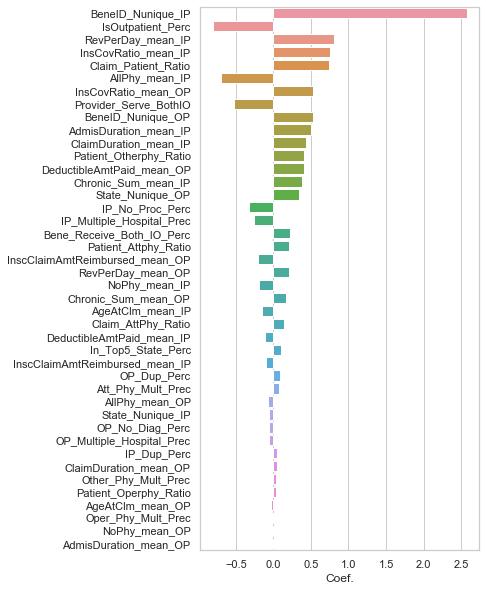

In [108]:
logistic_coef = pd.DataFrame(best_logistic.coef_.T, index = X.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
plt.figure(figsize = (5,10))
sns.barplot(data = logistic_coef.reset_index(), x = 'Coef.', y = 'index');
plt.ylabel('');

## Random Forest

In [67]:
randomForest = RandomForestClassifier(random_state = 0)
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
                   'max_depth': [10,15,20,30,40,50],
                   'max_features' : [5,7,10]}

In [68]:
grid_search_forest = GridSearchCV(randomForest, 
                                  grid_para_forest,
                                  cv=skf, n_jobs = 5, verbose = 1)
para_search = grid_search_forest.fit(X_train, y_train)
best_rf = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 17.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 46.7min
[Parallel(n_jobs=5)]: Done 450 out of 450 | elapsed: 49.8min finished


Best parameters: {'max_depth': 30, 'max_features': 5, 'n_estimators': 100}


In [78]:
eval_model('Random Forest', best_rf)

Random Forest score
------------------------------
Train: recall score: 1.0
Test: recall score: 0.98165


In [70]:
confusion_matrix(y_test,best_rf.predict(X_test))

array([[936,  45],
       [ 18, 963]])

Text(0, 0.5, 'Features')

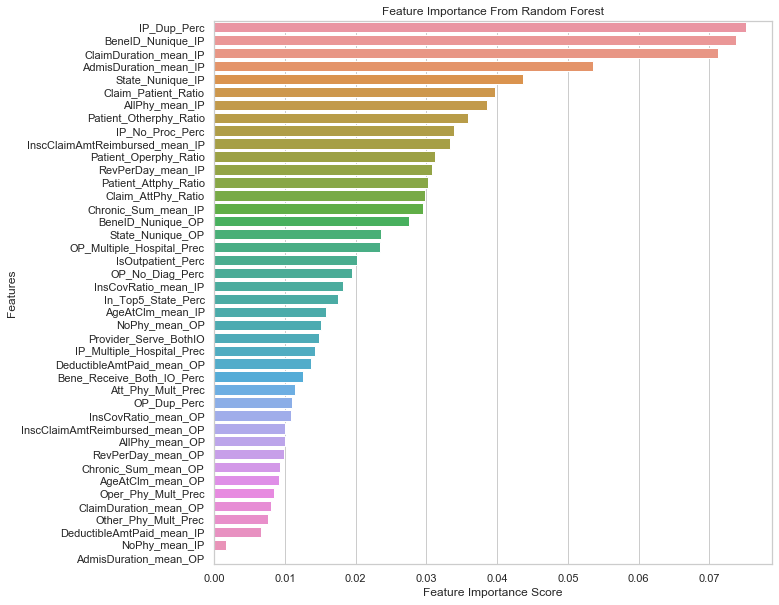

In [86]:
sorted_importance = sorted(zip(X.columns, best_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

## Gradient Boosting

In [82]:
gbm = GradientBoostingClassifier(random_state = 0)
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000],
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':range(1,6),
                   'max_features' : [5,7,15]}

In [83]:
grid_search_gb = GridSearchCV(gbm, 
                              grid_para_gb, 
                              cv= skf, n_jobs = 5, verbose = 1)
para_search = grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
print('Best parameters:', grid_search_gb.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   29.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 22.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 44.3min
[Parallel(n_jobs=5)]: Done 1125 out of 1125 | elapsed: 65.9min finished


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 7, 'n_estimators': 5000}


In [84]:
eval_model('Gradient Boosting', best_gb)

Gradient Boosting score
------------------------------
Train: recall score: 1.0
Test: recall score: 0.98879


Text(0, 0.5, 'Features')

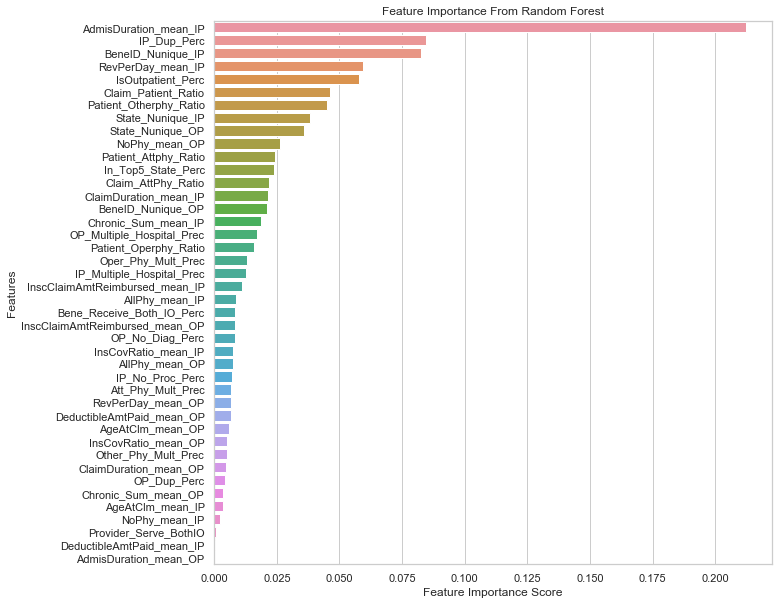

In [85]:
sorted_importance = sorted(zip(X.columns, best_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')